In [1]:
!pip install preliz

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [3]:
!pip install pymc-bart
import pymc_bart as pmb

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A desicion tree is a graph that sorts predictor values into different catagories based on yes or no (true or false) criteria.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a tree indicates how many "layers" it will have. If a tree is too deep, it will start to overfit. I there aren't enough layers, then the tree won't be able to capture most of the details of the data.

**Task4:**

How are BART models similar and different from a decision tree?

Bart is an intentional collection of descion trees. It acts on a random forest a tunes it to improve overfitting, underfitting, speed, and interpretability.

A single decsion tree on the other hand, only has one "outlook" on the data. It makes yes/no choices, but isn't necesarily the best interpreation of the data.

**Task5**:

Why would we use a BART model instead of a decision tree?

Like I said above, Bart is very intentional. Instead of just trying a bunch of trees in the hopes that one will be good like the random forest, it looks at the data and looks at the trees that can be made and picks out the ones that it thinks are relevant. It makes sure to not repeat patterns that other trees have already captured to mitigate overfitting by repeating patterns, or underfitting by never finding them in the firsy place.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [4]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [5]:
features = ["flipper_length", "bill_length", "bill_depth"]
X = penguins[features]
Y = penguins['body_mass']

In [6]:
with pm.Model() as model_peng:
    s = pm.Normal('s',20)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_peng = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

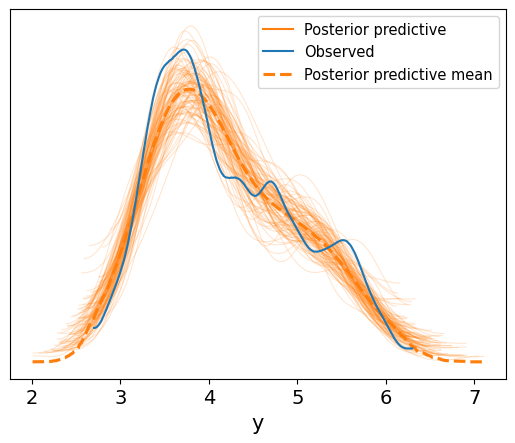

In [7]:
pm.sample_posterior_predictive(idata_peng,model_peng, extend_inferencedata=True)
az.plot_ppc(idata_peng, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


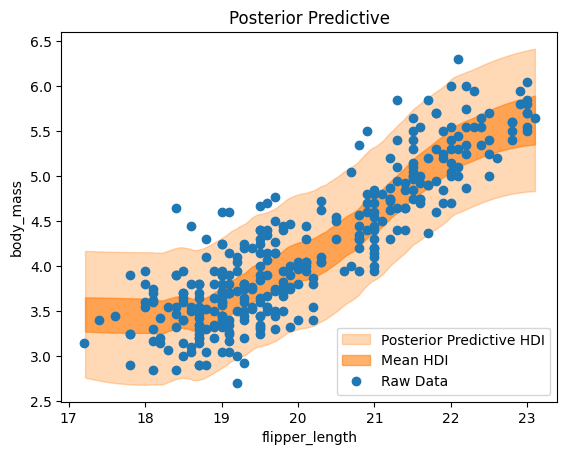

In [11]:

posterior_mean = idata_peng.posterior["μ"]

μ_hdi = az.hdi(ary=idata_peng, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_peng, group="posterior_predictive", var_names=["y"]).T


idx = np.argsort(X.to_numpy()[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I think the plot captures the data pretty well. It gets the broad "theme" of an upward trend, which is good... however, there are a few little things that it doesn't seem to be picking up on. The variance allowed shoud be slightly larger the the "beginning of the graph, then narrow in for the middle portion, ten increase again at the end. One thing that it does do that I think is cool ist that it captures the "s" shape of the data, whih is pretty nuanced of it beause it could easily just us a straight line there, so that's cool.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

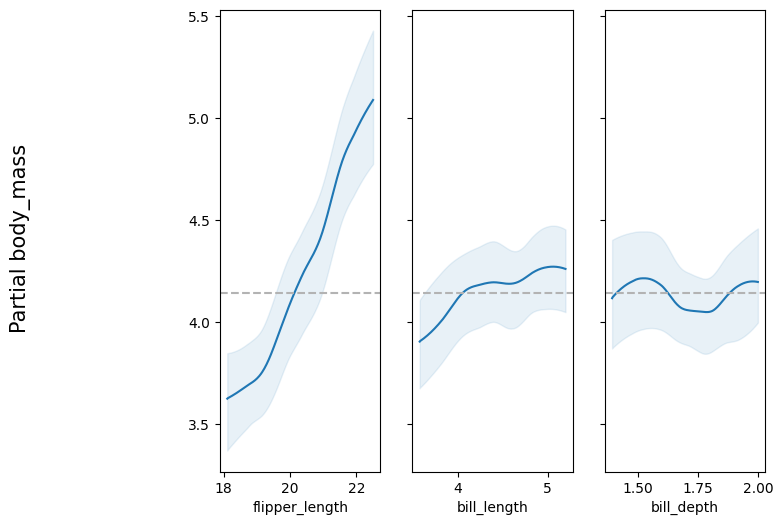

In [12]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

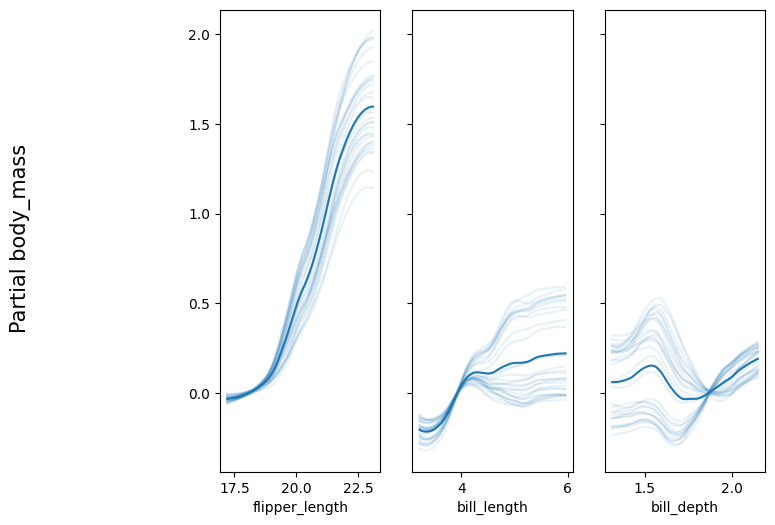

In [13]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

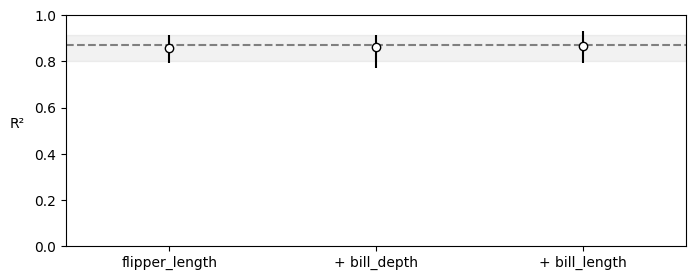

In [16]:
vi_penguins = pmb.compute_variable_importance(idata_peng, μ_, X)
pmb.plot_variable_importance(vi_penguins)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

I think that flipper length is the most important variable.

Looking the the fliper lenghth pdp, I see that it has the lowest variance out of all three variable and that it has a very distinct trend. This is promising because the low amounf of varience says that most of the data comforms to this trend.

Looking at the ice plot, it looks like the variance on flipper length increases a lot towards the end. This is intereting, but I wouldn't consider it and indaction of a strong interaction, because the shape itself isn't undergoing any major changes.

Finally, looking at the variable importance diagram, there is almost zero improvemnt between the models that use only flipper length versus the ones the use flipper length and other variables. That is almost a dead giveaway that flipper length is the most mportant variable for indicatin in the prediction of penguin body mass.